In [1]:
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saiprasadb2","key":"bb3547730482026e83d19af87d5b372a"}'}

In [3]:
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!ls ~/.kaggle


kaggle.json


In [6]:
!kaggle competitions download -c dogs-vs-cats


100% 810M/812M [00:20<00:00, 43.9MB/s]
100% 812M/812M [00:20<00:00, 42.0MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip



In [8]:
!unzip -qq train.zip


In [9]:
!ls train


cat.0.jpg      cat.1966.jpg  cat.5180.jpg  cat.8396.jpg   dog.1160.jpg	 dog.3575.jpg  dog.6790.jpg
cat.10000.jpg  cat.1967.jpg  cat.5181.jpg  cat.8397.jpg   dog.11610.jpg  dog.3576.jpg  dog.6791.jpg
cat.10001.jpg  cat.1968.jpg  cat.5182.jpg  cat.8398.jpg   dog.11611.jpg  dog.3577.jpg  dog.6792.jpg
cat.10002.jpg  cat.1969.jpg  cat.5183.jpg  cat.8399.jpg   dog.11612.jpg  dog.3578.jpg  dog.6793.jpg
cat.10003.jpg  cat.196.jpg   cat.5184.jpg  cat.839.jpg	  dog.11613.jpg  dog.3579.jpg  dog.6794.jpg
cat.10004.jpg  cat.1970.jpg  cat.5185.jpg  cat.83.jpg	  dog.11614.jpg  dog.357.jpg   dog.6795.jpg
cat.10005.jpg  cat.1971.jpg  cat.5186.jpg  cat.8400.jpg   dog.11615.jpg  dog.3580.jpg  dog.6796.jpg
cat.10006.jpg  cat.1972.jpg  cat.5187.jpg  cat.8401.jpg   dog.11616.jpg  dog.3581.jpg  dog.6797.jpg
cat.10007.jpg  cat.1973.jpg  cat.5188.jpg  cat.8402.jpg   dog.11617.jpg  dog.3582.jpg  dog.6798.jpg
cat.10008.jpg  cat.1974.jpg  cat.5189.jpg  cat.8403.jpg   dog.11618.jpg  dog.3583.jpg  dog.6799.jpg
cat.

Question 1:

copying images to the test, validation, and training directories

In [10]:
import os, shutil, pathlib

original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)


make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)

Loading and processing images with 'image_dataset_from_directory

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train = image_dataset_from_directory(
    base_dataset_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation = image_dataset_from_directory(
    base_dataset_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test = image_dataset_from_directory(
    base_dataset_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Construct a dataset with 1000 instances, each having 16 random values.

In [12]:
import numpy as np
import tensorflow as tf
random_num = np.random.normal(size=(1000, 16))
data = tf.data.Dataset.from_tensor_slices(random_num)

In [13]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
reshapedata = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshapedata):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Building a small neural network to differentiate dog and cat images

In [16]:
for data_batch, labels_batch in train:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape=(180, 180, 3))
l = layers.Rescaling(1./255)(input)
l = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.Flatten()(l)
l = layers.Dropout(0.5)(l)
output1 = layers.Dense(1, activation="sigmoid")(l)
model1 = keras.Model(inputs=input, outputs=output1)

preparing model for training

In [18]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

The model is initially developed, followed by training on the training set. To evaluate the model's performance at each stage, we utilize the validation set.

In [19]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

The dataset is used to refine the model's parameters.


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback1 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history1 = model1.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callback1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.4795 - loss: 0.7023 - val_accuracy: 0.5610 - val_loss: 0.6882
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5446 - loss: 0.6870 - val_accuracy: 0.5590 - val_loss: 0.6812
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5880 - loss: 0.6789 - val_accuracy: 0.6410 - val_loss: 0.6482
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6487 - loss: 0.6333 - val_accuracy: 0.6320 - val_loss: 0.6556
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6559 - loss: 0.6165 - val_accuracy: 0.6590 - val_loss: 0.6370
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6812 - loss: 0.6131 - val_accuracy: 0.6730 - val_loss: 0.6238
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6883 - loss: 0.5789 - val_accuracy: 0.6770 - val_loss: 0.6191
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6964 - loss: 0.5556 - val_accuracy: 0.6750 

To visualize the model's performance over time, training curves for accuracy and loss were created.


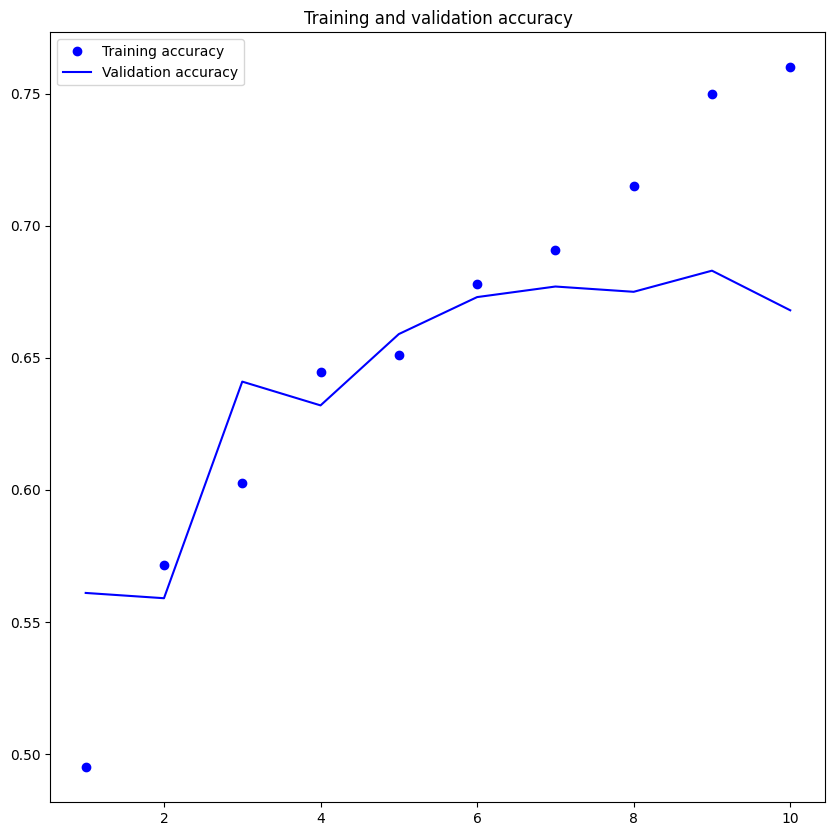

<Figure size 640x480 with 0 Axes>

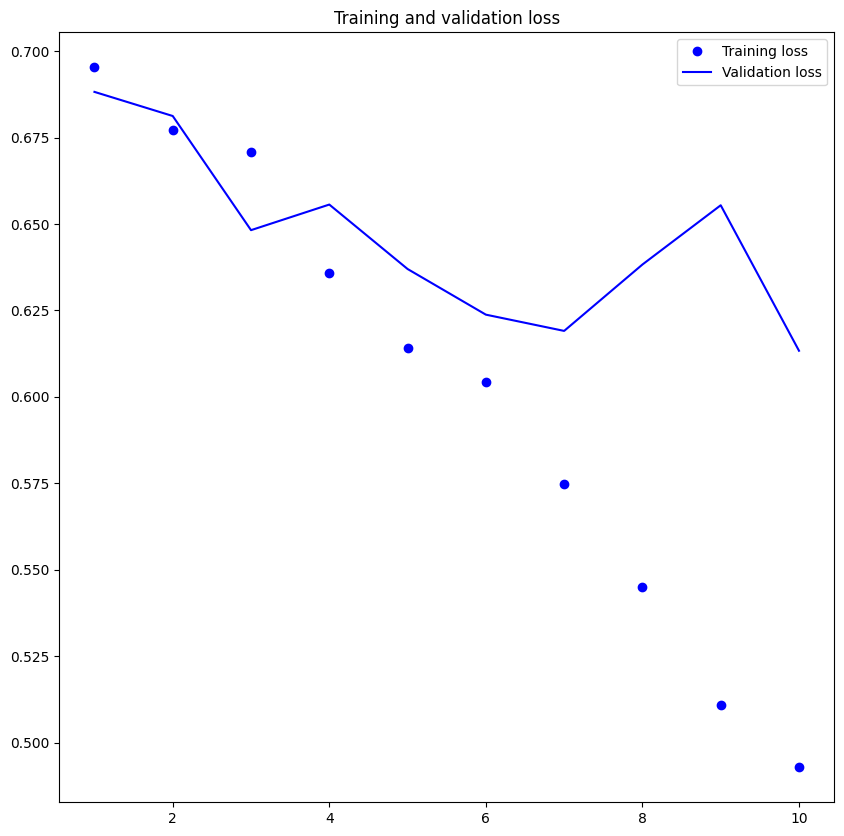

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy1 = history1.history["accuracy"]
val_accuracy1 = history1.history["val_accuracy"]
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)
plt.plot(epochs, accuracy1, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy1, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, val_loss1, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
testacc1 = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = testacc1.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7141 - loss: 0.6012
Test accuracy: 0.694


According to the above result, the test accuracy without data augmentation is about 69.3%, while the training accuracy is about 92%.


Question 2:

Expanding image dataset: Adding data augmentation to an image model.

In [23]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

# Defining the original directory and the new base directory
original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small_Q2")

# Functions to create subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directory, if it doesn't exist
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)

# Creating subsets for training, validation, and testing
make_subset("train", start_index=667, end_index=2167)  # 1500 samples
make_subset("validation", start_index=2168, end_index=2668)  # 500 samples
make_subset("test", start_index=2669, end_index=3168)  # 500 samples


In [24]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

showing the training augmented pictures

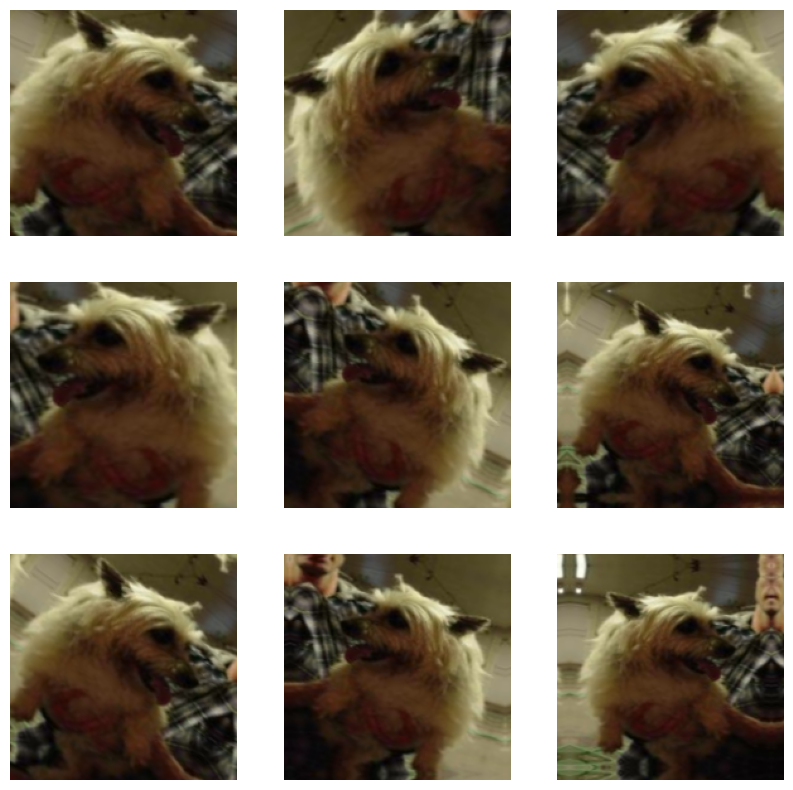

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_pics = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_pics[0].numpy().astype("uint8"))
        plt.axis("off")

Developing a new convolutional neural network that includes picture augmentation and dropout


In [26]:
input2 = keras.Input(shape=(180, 180, 3))
m = augmentation(input2)
m = layers.Rescaling(1./255)(m)
m = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.Flatten()(m)
m = layers.Dropout(0.5)(m)
output2 = layers.Dense(1, activation="sigmoid")(m)
model2 = keras.Model(inputs=input2, outputs=output2)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model2.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callback2)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.4737 - loss: 0.7033 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5221 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5099 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5111 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.5081 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5048 - loss: 0.6933 - val_accuracy: 0.5000 - 

Model evaluated based on test set

In [28]:
testacc2 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = testacc2.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6817 - loss: 0.6108
Test accuracy: 0.681


Question 3:

In the third step, training sets of 2000 samples were employed, with 500 samples reserved for validation and testing. I discovered that the test accuracy was superior with 1500 training samples compared to 1000 or 2000. Moreover, training accuracy improved with 1000 training samples. Increasing the training set to 2000 while maintaining the same validation and testing sets resulted in these findings.

In [29]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

Click enter to edit the data

In [30]:
i3 = keras.Input(shape=(180, 180, 3))
n = augmentation(i3)
n = layers.Rescaling(1./255)(n)
n = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.Flatten()(n)
n = layers.Dropout(0.5)(n)
out3 = layers.Dense(1, activation="sigmoid")(n)
mod3 = keras.Model(inputs=i3, outputs=out3)

mod3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [31]:
callback3 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
hist3 = mod3.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=callback3)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5108 - loss: 0.6981 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.5680 - val_loss: 0.6824
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5679 - loss: 0.6812 - val_accuracy: 0.5120 - val_loss: 0.8360
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5527 - loss: 0.6892 - val_accuracy: 0.5900 - val_loss: 0.6861
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5864 - loss: 0.6810 - val_accuracy: 0.6370 - val_loss: 0.6504
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5966 - loss: 0.6604 - val_accuracy: 0.6420 - val_loss: 0.6431
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6231 - loss: 0.6449 - val_accuracy: 0.6110 - val_loss: 0.6808
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5979 - loss: 0.6577 - val_accuracy: 0.6210 - v

In [32]:
acc_test3 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = acc_test3.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8082 - loss: 0.4204
Test accuracy: 0.791


Question 4:


Creating the VGG16 convolutional base

In [33]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [34]:
convolution_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Utilizing a pre-trained model for feature extraction without data augmentation: Obtaining the labels associated with the VGG16 characteristics

In [35]:
import numpy as np

def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)

train_features, train_labels =  get_features_and_labels(train)
val_features, val_labels =  get_features_and_labels(validation)
test_features, test_labels =  get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [36]:
train_features.shape

(2000, 5, 5, 512)

In [37]:
i6 = keras.Input(shape=(5, 5, 512))
p = layers.Flatten()(i6)
p = layers.Dense(256)(p)
p = layers.Dropout(0.5)(p)
out6 = layers.Dense(1, activation="sigmoid")(p)
m6 = keras.Model(i6, out6)
m6.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callback6 = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
hist6 = m6.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callback6)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8727 - loss: 32.9241 - val_accuracy: 0.9250 - val_loss: 13.5025
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9452 - loss: 12.3289 - val_accuracy: 0.9730 - val_loss: 5.5861
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9847 - loss: 1.6182 - val_accuracy: 0.9710 - val_loss: 4.4519
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9887 - loss: 1.0170 - val_accuracy: 0.9710 - val_loss: 4.6733
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 1.3553 - val_accuracy: 0.9560 - val_loss: 10.6425
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 1.4510 - val_accuracy: 0.9730 - val_loss: 5.6442
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9936 - loss: 0.2816 - val_accuracy: 0.9730 - val_loss: 6.4222
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.8262 - val_accuracy: 0.9740 - val

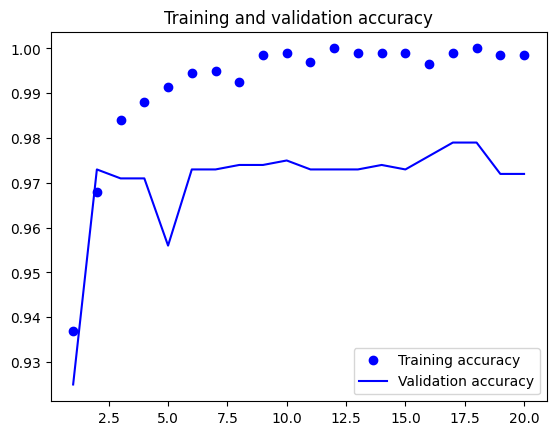

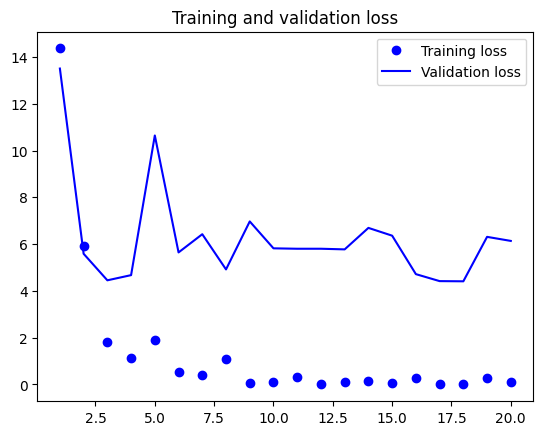

In [38]:
import matplotlib.pyplot as plt
accuracy6 = hist6.history["accuracy"]
valaccuracy6 = hist6.history["val_accuracy"]
los6 = hist6.history["loss"]
vallos6 = hist6.history["val_loss"]
epochs = range(1, len(accuracy6) + 1)
plt.plot(epochs, accuracy6, "bo", label="Training accuracy")
plt.plot(epochs, valaccuracy6, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, los6, "bo", label="Training loss")
plt.plot(epochs, vallos6, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


VGG16 convolutional base instantiation and freezing

In [39]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

convolution_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

convolution_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Model is now performing with a classifier and agumentation to convulation base

In [40]:
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
     lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.8590 - loss: 16.5827 - val_accuracy: 0.9640 - val_loss: 5.2451
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9631 - loss: 3.7859 - val_accuracy: 0.9740 - val_loss: 3.4048
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.9553 - loss: 5.9983 - val_accuracy: 0.9530 - val_loss: 8.6423
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9607 - loss: 5.1624 - val_accuracy: 0.9750 - val_loss: 3.8093
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9648 - loss: 4.0427 - val_accuracy: 0.9790 - val_loss: 3.2267
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9729 - loss: 4.4778 - val_accuracy: 0.9760 - val_loss: 3.9459
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.9637 - loss: 4.4014 - val_accuracy: 0.9780 - val_loss: 3.6663
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9666 - loss: 3.5087 - val_acc

In [42]:
!ls -lh features_extraction_with_augmentation2.keras


-rw-r--r-- 1 root root 82M Oct 21 17:38 features_extraction_with_augmentation2.keras


In [43]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16

# Define the model
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))

a1 = augmentation2(input22)

# Specify output_shape for Lambda layer
a1 = keras.layers.Lambda(
    lambda x: vgg16.preprocess_input(x),
    output_shape=(180, 180, 3)
)(a1)

a1 = convolution_base(a1)
a1 = layers.Flatten()(a1)
a1 = layers.Dense(256)(a1)
a1 = layers.Dropout(0.5)(a1)
outputs = layers.Dense(1, activation="sigmoid")(a1)

model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Save the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.8476 - loss: 41.4093 - val_accuracy: 0.9470 - val_loss: 6.1806
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9501 - loss: 7.1782 - val_accuracy: 0.9730 - val_loss: 3.2381
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.9559 - loss: 5.0149 - val_accuracy: 0.9580 - val_loss: 6.2669
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9623 - loss: 4.4803 - val_accuracy: 0.9800 - val_loss: 2.4848
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.9632 - loss: 4.3496 - val_accuracy: 0.9670 - val_loss: 4.6468
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9689 - loss: 4.3989 - val_accuracy: 0.9680 - val_loss: 5.9931
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9724 - loss: 3.4254 - val_accuracy: 0.9740 - val_loss: 3.6179
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.9783 - loss: 2.6997 - val_acc

Fine-tuning a pretrained model

Freezing all layers until the fourth from the last

In [44]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbackstu = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
historytune = model.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callbackstu)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.9733 - loss: 2.4801 - val_accuracy: 0.9850 - val_loss: 1.8703
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9835 - loss: 1.0652 - val_accuracy: 0.9840 - val_loss: 1.6904
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.9913 - loss: 0.5108 - val_accuracy: 0.9800 - val_loss: 1.6851
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9819 - loss: 0.8346 - val_accuracy: 0.9840 - val_loss: 1.6190
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.9855 - loss: 0.6624 - val_accuracy: 0.9850 - val_loss: 1.2894
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9889 - loss: 0.6569 - val_accuracy: 0.9840 - val_loss: 1.3635
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.9953 - loss: 0.1888 - val_accuracy: 0.9820 - val_loss: 1.1596
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.9860 - loss: 0.5612 - val_accu

In [46]:
model_tuning = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9690 - loss: 2.4987
Test accuracy: 0.973
